In [38]:
%reload_ext autoreload
%autoreload 2
from alpharaw.ms_data_base import ms_reader_provider
from alpharaw import register_all_readers
from dia_aspire_rescore.io import read_diann2
from dia_aspire_rescore.plot import plot_qvalues, plot_target_decoy_dist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dia_aspire_rescore.psm.matcher import DIAPeptideSpectrumMatcher
from alphabase.peptide.fragment import create_fragment_mz_dataframe, flatten_fragments
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
register_all_readers()


In [39]:
psm_df_original = read_diann2("../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
# decreasing nAA order, https://github.com/MannLabs/alphadia/pull/409
psm_df_original = psm_df_original.sort_values(by="nAA", ascending=True).reset_index(drop=True)
psm_df_original

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr1_search1,fdr2_search1,fdr1_search2,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,YQYYHRYY,3,44.166344,44.104832,44.227886,0.0,1/sp|O96000|NDUBA_HUMAN,1/sp|O96000|NDUBA_HUMAN,,...,0.264773,1.000000,0.0,0.0,,,8,0.369029,419.189212,0.0
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,ERMGANSL,2,38.052963,37.930332,38.206379,0.0,1/sp|P52272|HNRPM_HUMAN,1/sp|P52272|HNRPM_HUMAN,,...,0.157135,0.000124,0.0,0.0,,,8,0.317949,439.213452,0.0
2,20200317_QE_HFX2_LC3_DIA_RA957_R02,ERMGANSL,2,37.944874,37.852745,38.129253,0.0,1/sp|P52272|HNRPM_HUMAN,1/sp|P52272|HNRPM_HUMAN,,...,0.157135,0.000124,0.0,0.0,,,8,0.317283,439.213452,0.0
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGASL,1,73.935051,73.812119,74.120216,0.0,1/sp|Q9Y6J0|CABIN_HUMAN,1/sp|Q9Y6J0|CABIN_HUMAN,,...,0.000224,0.000124,0.0,0.0,,,8,0.617759,711.403566,0.0
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGAEL,1,79.160156,79.067657,79.252640,0.0,2/sp|Q5U651|RAIN_HUMAN/tr|M0R148|M0R148_HUMAN,2/sp|Q5U651|RAIN_HUMAN/tr|M0R148|M0R148_HUMAN,,...,0.179222,1.000000,0.0,0.0,,,8,0.661417,753.414131,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338834,20200317_QE_HFX2_LC3_DIA_RA957_R02,SSFPSASLGKASVR,2,58.953045,58.828590,59.046440,0.0,1/sp|Q9NWN3|FBX34_HUMAN,1/sp|Q9NWN3|FBX34_HUMAN,,...,1.000000,1.000000,0.0,0.0,,,14,0.492947,697.375340,0.0
338835,20200317_QE_HFX2_LC3_DIA_RA957_R02,DAFNHLTTWLEDTR,3,107.905006,107.873901,108.122513,0.0,3/tr|H7C125|H7C125_HUMAN/tr|E9PKL7|E9PKL7_HUMA...,3/tr|H7C125|H7C125_HUMAN/tr|E9PKL7|E9PKL7_HUMA...,,...,0.443320,1.000000,0.0,0.0,,,14,0.902269,573.609276,0.0
338836,20200317_QE_HFX2_LC3_DIA_RA957_R02,DTFRPDLSSASFSR,3,73.220573,72.975151,73.312637,0.0,1/sp|Q13077|TRAF1_HUMAN,1/sp|Q13077|TRAF1_HUMAN,,...,1.000000,1.000000,0.0,0.0,,,14,0.612248,529.258355,0.0
338837,20200317_QE_HFX2_LC3_DIA_RA957_R01,SFHDPAGALQAAVR,2,75.013031,74.829079,75.197029,0.0,1/sp|O15533|TPSN_HUMAN,1/sp|O15533|TPSN_HUMAN,,...,1.000000,1.000000,0.0,0.0,,,14,0.626766,720.373132,0.0


In [40]:
spec_dict = {}
peak_dict = {}

for run in psm_df_original['raw_name'].unique():
    hdf_reader = ms_reader_provider.get_reader("hdf5")
    hdf_reader.load_raw(f"./output/{run}.mzML.hdf5")
    spec_dict[run] = hdf_reader.spectrum_df
    peak_dict[run] = hdf_reader.peak_df

In [41]:
matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)
psm_df_top = psm_df_original[
    (psm_df_original['fdr1_search1'] < 0.01) & (psm_df_original['fdr2_search1'] < 0.01)].reset_index(drop=True).copy()
psm_df_matched, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df_original,
    {'20200317_QE_HFX2_LC3_DIA_RA957_R01': './output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
     '20200317_QE_HFX2_LC3_DIA_RA957_R02': './output/20200317_QE_HFX2_LC3_DIA_RA957_R02.mzML.hdf5'},
    'hdf5',
)

100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


In [42]:
psm_df_top = psm_df_original[
    (psm_df_original['fdr1_search1'] < 0.01) & (psm_df_original['fdr2_search1'] < 0.01)].reset_index(drop=True).copy()
psm_df_top_matched, fragment_mz_df_top, matched_intensity_df_top, matched_mz_err_df_top = matcher.match_ms2_multi_raw(
    psm_df_top,
    {'20200317_QE_HFX2_LC3_DIA_RA957_R01': './output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
     '20200317_QE_HFX2_LC3_DIA_RA957_R02': './output/20200317_QE_HFX2_LC3_DIA_RA957_R02.mzML.hdf5'},
    'hdf5',
)
psm_df_top_matched

100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs,frag_start_idx,frag_stop_idx,spec_idx
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGASL,1,73.935051,73.812119,74.120216,0.0,1/sp|Q9Y6J0|CABIN_HUMAN,1/sp|Q9Y6J0|CABIN_HUMAN,,...,0.0,,,8,0.617759,711.403566,0.0,0,7,54755
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPAESL,1,75.566612,75.290459,75.842407,0.0,1/sp|Q86WR7|PRSR2_HUMAN,1/sp|Q86WR7|PRSR2_HUMAN,,...,0.0,,,8,0.631391,783.424696,0.0,7,14,55953
2,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPNPIL,1,97.764778,97.581024,97.948593,0.0,1/sp|Q9Y3I1|FBX7_HUMAN,1/sp|Q9Y3I1|FBX7_HUMAN,,...,0.0,,,8,0.816866,820.492716,0.0,28,35,72560
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPLHSL,2,79.329109,79.206001,79.513298,0.0,1/sp|Q8WXH0|SYNE2_HUMAN,1/sp|Q8WXH0|SYNE2_HUMAN,,...,0.0,,,8,0.662829,417.247621,0.0,42,49,58768
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGSSL,1,69.359787,69.237015,69.513115,0.0,1/sp|Q92545|TM131_HUMAN,1/sp|Q92545|TM131_HUMAN,,...,0.0,,,8,0.579531,727.398481,0.0,56,63,51329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79410,20200317_QE_HFX2_LC3_DIA_RA957_R02,NTFEIHDDIEVLKR,3,75.835625,75.712906,75.927582,0.0,2/sp|Q14186|TFDP1_HUMAN/sp|Q14188|TFDP2_HUMAN,2/sp|Q14186|TFDP1_HUMAN/sp|Q14188|TFDP2_HUMAN,,...,0.0,,,14,0.634114,576.968693,0.0,677353,677366,56038
79411,20200317_QE_HFX2_LC3_DIA_RA957_R02,ESKEQVANSAFVER,3,46.451649,46.236031,46.544449,0.0,2/sp|Q58FF7|H90B3_HUMAN/sp|P08238|HS90B_HUMAN,2/sp|Q58FF7|H90B3_HUMAN/sp|P08238|HS90B_HUMAN,,...,0.0,,,14,0.388415,531.933759,0.0,677405,677418,34163
79412,20200317_QE_HFX2_LC3_DIA_RA957_R02,ESKEQVANSAFVER,2,44.724854,44.599941,44.817566,0.0,2/sp|Q58FF7|H90B3_HUMAN/sp|P08238|HS90B_HUMAN,2/sp|Q58FF7|H90B3_HUMAN/sp|P08238|HS90B_HUMAN,,...,0.0,,,14,0.373976,797.397001,0.0,677431,677444,32908
79413,20200317_QE_HFX2_LC3_DIA_RA957_R02,EIAPHALLQAVLKR,3,93.210526,93.086617,93.303337,0.0,1/sp|P49327|FAS_HUMAN,1/sp|P49327|FAS_HUMAN,,...,0.0,,,14,0.779398,520.319109,0.0,677457,677470,69030


In [43]:
from peptdeep.pretrained_models import ModelManager

mgr = ModelManager(
    mask_modloss=True,
)

mgr.train_verbose = True
mgr.nce = 27.5
mgr.instrument = 'QE'
mgr.load_installed_models('generic')

In [44]:
# Before fine-tuning
psm_df_before = psm_df_original.copy()
intensity_before = mgr.predict_ms2(psm_df_before)

2025-11-21 13:07:42> Predicting MS2 ...


100%|██████████| 7/7 [01:42<00:00, 14.61s/it]


In [45]:
psm_df_before

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs,nce,instrument,frag_start_idx,frag_stop_idx
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,YQYYHRYY,3,44.166344,44.104832,44.227886,0.0,1/sp|O96000|NDUBA_HUMAN,1/sp|O96000|NDUBA_HUMAN,,...,,,8,0.369029,419.189212,0.0,27.5,QE,0,7
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,ERMGANSL,2,38.052963,37.930332,38.206379,0.0,1/sp|P52272|HNRPM_HUMAN,1/sp|P52272|HNRPM_HUMAN,,...,,,8,0.317949,439.213452,0.0,27.5,QE,7,14
2,20200317_QE_HFX2_LC3_DIA_RA957_R02,ERMGANSL,2,37.944874,37.852745,38.129253,0.0,1/sp|P52272|HNRPM_HUMAN,1/sp|P52272|HNRPM_HUMAN,,...,,,8,0.317283,439.213452,0.0,27.5,QE,14,21
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGASL,1,73.935051,73.812119,74.120216,0.0,1/sp|Q9Y6J0|CABIN_HUMAN,1/sp|Q9Y6J0|CABIN_HUMAN,,...,,,8,0.617759,711.403566,0.0,27.5,QE,21,28
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGAEL,1,79.160156,79.067657,79.252640,0.0,2/sp|Q5U651|RAIN_HUMAN/tr|M0R148|M0R148_HUMAN,2/sp|Q5U651|RAIN_HUMAN/tr|M0R148|M0R148_HUMAN,,...,,,8,0.661417,753.414131,0.0,27.5,QE,28,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338834,20200317_QE_HFX2_LC3_DIA_RA957_R02,SSFPSASLGKASVR,2,58.953045,58.828590,59.046440,0.0,1/sp|Q9NWN3|FBX34_HUMAN,1/sp|Q9NWN3|FBX34_HUMAN,,...,,,14,0.492947,697.375340,0.0,27.5,QE,2847638,2847651
338835,20200317_QE_HFX2_LC3_DIA_RA957_R02,DAFNHLTTWLEDTR,3,107.905006,107.873901,108.122513,0.0,3/tr|H7C125|H7C125_HUMAN/tr|E9PKL7|E9PKL7_HUMA...,3/tr|H7C125|H7C125_HUMAN/tr|E9PKL7|E9PKL7_HUMA...,,...,,,14,0.902269,573.609276,0.0,27.5,QE,2847651,2847664
338836,20200317_QE_HFX2_LC3_DIA_RA957_R02,DTFRPDLSSASFSR,3,73.220573,72.975151,73.312637,0.0,1/sp|Q13077|TRAF1_HUMAN,1/sp|Q13077|TRAF1_HUMAN,,...,,,14,0.612248,529.258355,0.0,27.5,QE,2847664,2847677
338837,20200317_QE_HFX2_LC3_DIA_RA957_R01,SFHDPAGALQAAVR,2,75.013031,74.829079,75.197029,0.0,1/sp|O15533|TPSN_HUMAN,1/sp|O15533|TPSN_HUMAN,,...,,,14,0.626766,720.373132,0.0,27.5,QE,2847677,2847690


In [46]:
intensity_before

,b_z1,b_z2,y_z1,y_z2
0,0.000000,0.0,0.000000,0.000000
1,0.215536,0.0,0.095957,0.095606
2,0.017464,0.0,0.669691,0.182921
3,0.000000,0.0,1.000000,0.387422
4,0.000000,0.0,0.474977,0.000000
...,...,...,...,...
2847698,0.000000,0.0,0.000000,0.000000
2847699,0.042779,0.0,0.135630,0.000000
2847700,0.055939,0.0,1.000000,0.000000
2847701,0.000000,0.0,0.074940,0.000000


In [47]:
# Calculate MS2 similarity metrics BEFORE fine-tuning
from peptdeep.model.ms2 import calc_ms2_similarity

psm_df_before, metrics_before = calc_ms2_similarity(
    psm_df_before,
    intensity_before,
    matched_intensity_df,
    charged_frag_types=None,
    metrics=['PCC','COS','SA','SPC'],
)

metrics_before

,PCC,COS,SA,SPC
count,338839.000000,338839.000000,338839.000000,338839.000000
mean,0.298502,0.386708,0.277196,-0.140932
std,0.331118,0.295263,0.237286,0.430833
min,-0.274957,0.000000,0.000000,-1.604472
25%,0.012562,0.132566,0.084644,-0.461261
50%,0.207538,0.313326,0.202887,-0.193658
75%,0.555275,0.617369,0.423603,0.179069
max,0.999468,0.999459,0.979065,1.000000
>0.90,0.064107,0.076316,0.004034,0.001827
>0.75,0.146878,0.169367,0.057656,0.014024


In [48]:
# Prepare data for visualization (Before Fine-tuning)
metrics = ['PCC', 'COS', 'SA', 'SPC']
fdr_col = 'fdr1_search1'

target_df_before = psm_df_before[psm_df_before['decoy'] == 0].copy()
decoy_df_before = psm_df_before[psm_df_before['decoy'] == 1].copy()

print(f"Before Fine-tuning:")
print(f"  Total PSMs: {len(psm_df_before):,}")
print(f"  Target PSMs: {len(target_df_before):,}")
print(f"  Decoy PSMs: {len(decoy_df_before):,}")
print(f"  FDR range: {psm_df_before[fdr_col].min():.4f} - {psm_df_before[fdr_col].max():.4f}")


Before Fine-tuning:
  Total PSMs: 338,839
  Target PSMs: 174,407
  Decoy PSMs: 164,432
  FDR range: 0.0000 - 1.0000


In [49]:
from peptdeep.rescore.fdr import calc_fdr
psm_df_before = calc_fdr(psm_df_before, 'SPC')
psm_df_before

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,precursor_mz,ccs,nce,instrument,frag_start_idx,frag_stop_idx,PCC,COS,SA,SPC
185925,20200317_QE_HFX2_LC3_DIA_RA957_R02,YPQEVIPTF,1,107.857773,107.640800,108.013008,0.0,1/sp|P33991|MCM4_HUMAN,1/sp|P33991|MCM4_HUMAN,,...,1093.556438,0.0,27.5,QE,1470991,1470999,0.949034,0.955888,0.810206,1.000000
120304,20200317_QE_HFX2_LC3_DIA_RA957_R02,QRIDSDDAL,1,44.105789,43.981167,44.292515,0.0,1/sp|P50750|CDK9_HUMAN,1/sp|P50750|CDK9_HUMAN,,...,1032.495629,0.0,27.5,QE,946023,946031,0.992481,0.993301,0.926269,0.999633
96286,20200317_QE_HFX2_LC3_DIA_RA957_R01,IHDGMNLEL,1,62.173035,62.019444,62.326965,0.0,1/sp|Q9BZL1|UBL5_HUMAN,1/sp|Q9BZL1|UBL5_HUMAN,,...,1057.498272,0.0,27.5,QE,753879,753887,0.934946,0.948217,0.794231,0.998900
53159,20200317_QE_HFX2_LC3_DIA_RA957_R02,FPQAEDLYL,1,106.898491,106.652061,107.114410,0.0,1/sp|Q6ZMG9|CERS6_HUMAN,1/sp|Q6ZMG9|CERS6_HUMAN,,...,1095.535703,0.0,27.5,QE,408863,408871,0.982086,0.985271,0.890599,0.998534
87681,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPVVDFNEM,1,110.498207,110.343422,110.653168,0.0,1/sp|Q16236|NF2L2_HUMAN,1/sp|Q16236|NF2L2_HUMAN,,...,1063.512859,0.0,27.5,QE,685039,685047,0.996267,0.996563,0.947201,0.998534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192181,20200317_QE_HFX2_LC3_DIA_RA957_R01,QRVAIFTSY,2,111.598030,111.535881,111.660042,0.0,1/uc001omw.1,1/uc001omw.1,,...,542.792924,0.0,27.5,QE,1521039,1521047,-0.151050,0.008619,0.005487,-1.540323
217672,20200317_QE_HFX2_LC3_DIA_RA957_R02,GEPGGIHYV,2,54.703548,54.579441,54.796806,0.0,2/sp|K22E_HUMAN|/sp|P35908|K22E_HUMAN,2/sp|K22E_HUMAN|/sp|P35908|K22E_HUMAN,,...,464.729792,0.0,27.5,QE,1724967,1724975,-0.266768,0.000000,0.000000,-1.596591
8000,20200317_QE_HFX2_LC3_DIA_RA957_R02,PSFPSVRL,2,86.786964,86.509850,87.063889,0.0,1/sp|Q16378|PROL4_HUMAN,1/sp|Q16378|PROL4_HUMAN,,...,451.758352,0.0,27.5,QE,56000,56007,-0.162823,0.000000,0.000000,-1.598248
7999,20200317_QE_HFX2_LC3_DIA_RA957_R01,PSFPSVRL,2,86.835945,86.651436,86.989609,0.0,1/sp|Q16378|PROL4_HUMAN,1/sp|Q16378|PROL4_HUMAN,,...,451.758352,0.0,27.5,QE,55993,56000,-0.195797,0.000672,0.000428,-1.598522


<Axes: xlabel='q-value', ylabel='Discoveries'>

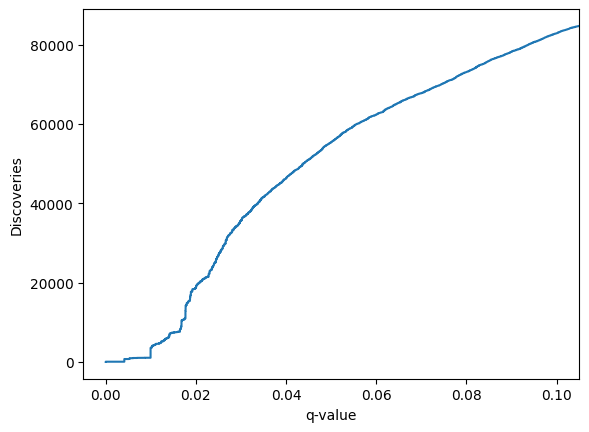

In [50]:
plot_qvalues(psm_df_before['fdr'])

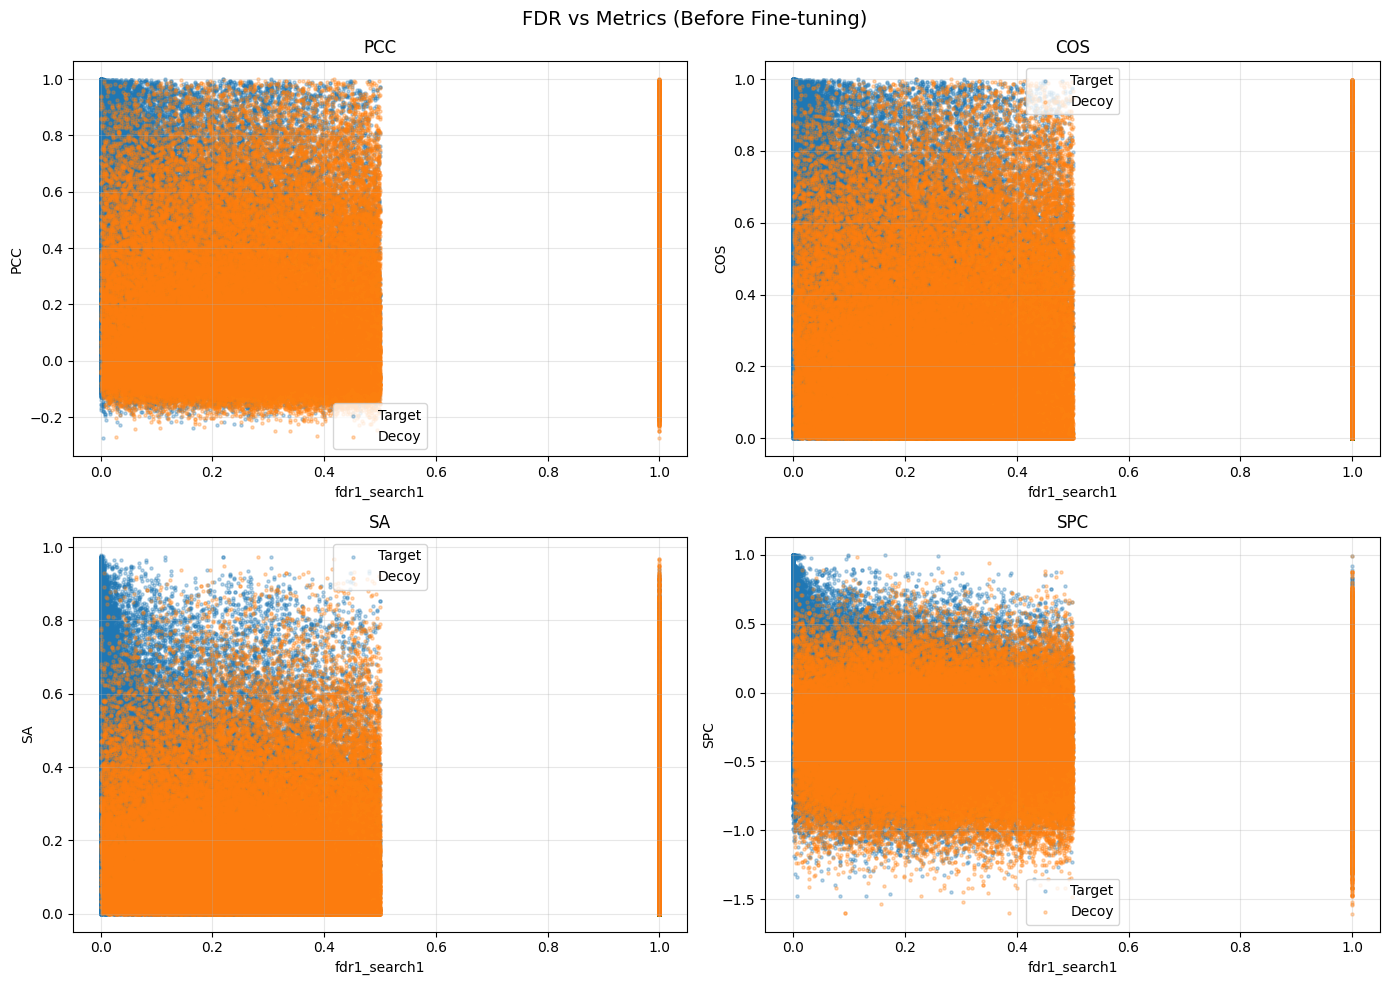

In [51]:
# Relationship: FDR vs Metrics (Before Fine-tuning)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('FDR vs Metrics (Before Fine-tuning)', fontsize=14)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    ax.scatter(target_df_before[fdr_col], target_df_before[metric], 
               alpha=0.3, s=5, label='Target')
    ax.scatter(decoy_df_before[fdr_col], decoy_df_before[metric], 
               alpha=0.3, s=5, label='Decoy')
    
    ax.set_xlabel(fdr_col)
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

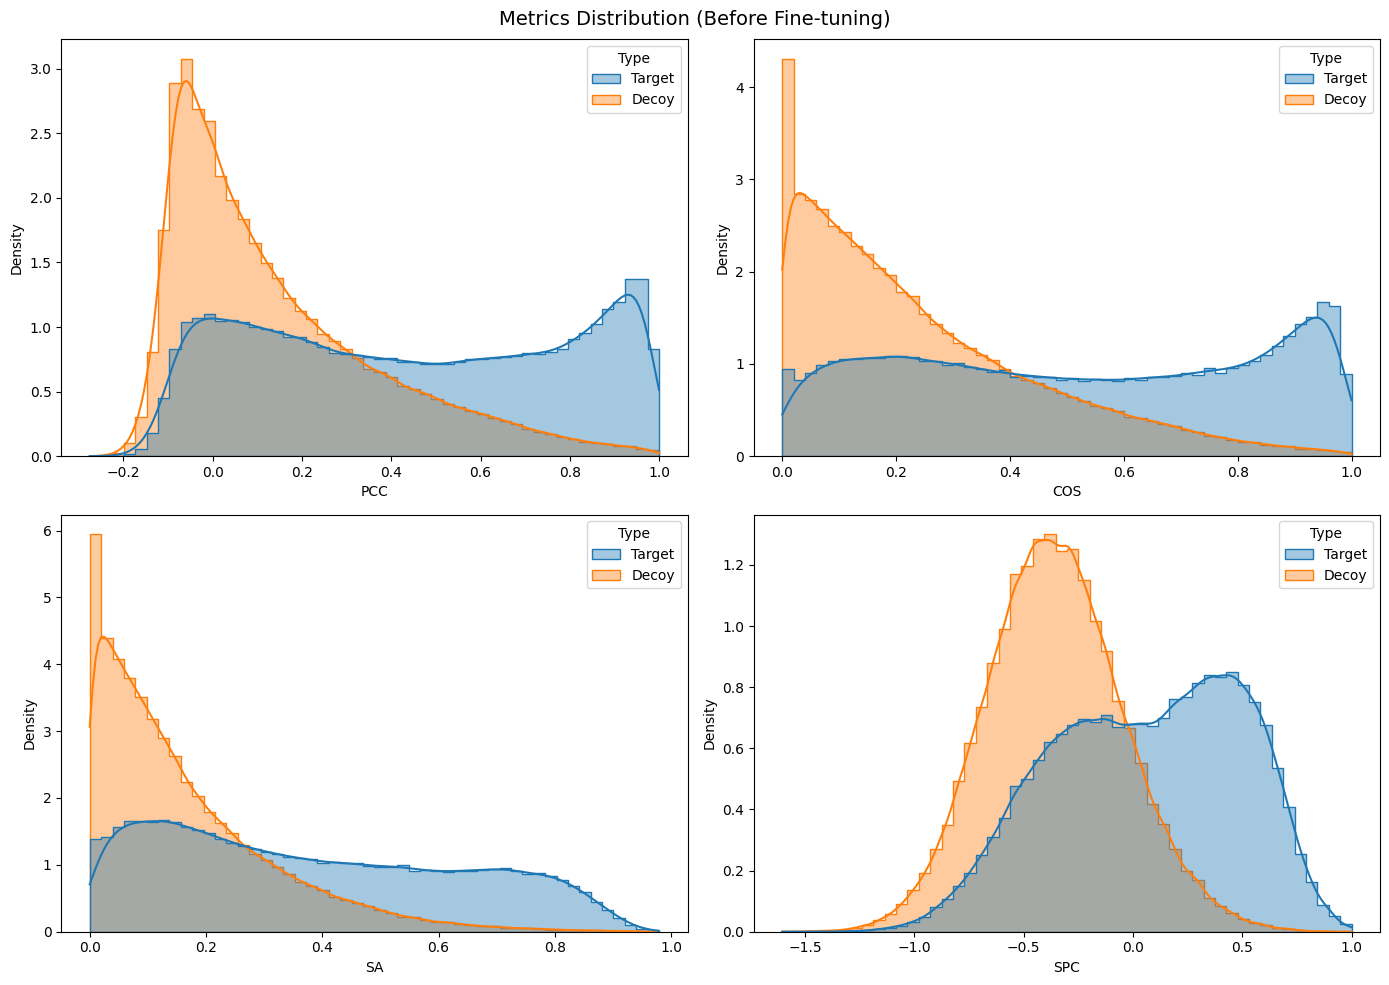

In [52]:
# Distribution: Metrics Distribution (Before Fine-tuning)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Metrics Distribution (Before Fine-tuning)', fontsize=14)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    plot_target_decoy_dist(psm_df_before, metric, ax=ax)

plt.tight_layout()
plt.show()

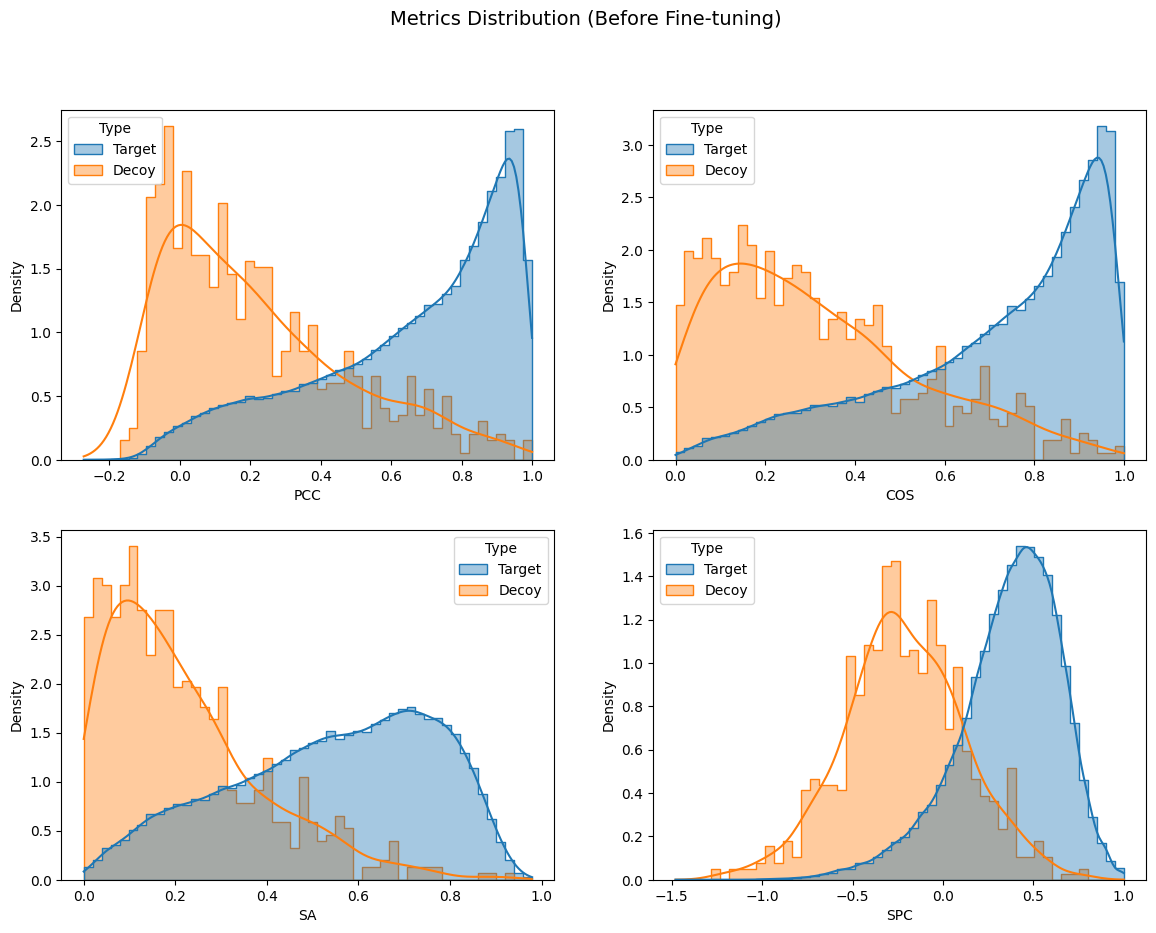

In [53]:
# filter the psm that fdr1_search1 < 0.01, and show the 4 metrics  distribution
psm_df_before_filtered = psm_df_before[psm_df_before['fdr1_search1'] < 0.01]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Metrics Distribution (Before Fine-tuning)', fontsize=14)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    plot_target_decoy_dist(psm_df_before_filtered, metric, ax=ax)

In [54]:
# Summary: Before Fine-tuning
print("="*70)
print("Summary: Before Fine-tuning")
print("="*70)

print("\n1. Overall Statistics:")
print(f"   Total PSMs: {len(psm_df_before):,}")
print(f"   Target PSMs: {len(target_df_before):,} ({len(target_df_before)/len(psm_df_before)*100:.1f}%)")
print(f"   Decoy PSMs: {len(decoy_df_before):,} ({len(decoy_df_before)/len(psm_df_before)*100:.1f}%)")

print("\n2. Mean Values:")
for metric in metrics:
    target_mean = target_df_before[metric].mean()
    decoy_mean = decoy_df_before[metric].mean()
    diff = target_mean - decoy_mean
    print(f"   {metric}: Target={target_mean:.4f}, Decoy={decoy_mean:.4f}, Diff={diff:+.4f}")

print("\n3. Statistics by Target/Decoy:")
print("\nTarget PSMs:")
print(target_df_before[metrics].describe())
print("\nDecoy PSMs:")
print(decoy_df_before[metrics].describe())


Summary: Before Fine-tuning

1. Overall Statistics:
   Total PSMs: 338,839
   Target PSMs: 174,407 (51.5%)
   Decoy PSMs: 164,432 (48.5%)

2. Mean Values:
   PCC: Target=0.4433, Decoy=0.1449, Diff=+0.2985
   COS: Target=0.5189, Decoy=0.2465, Diff=+0.2724
   SA: Target=0.3828, Decoy=0.1652, Diff=+0.2176
   SPC: Target=0.0616, Decoy=-0.3558, Diff=+0.4174

3. Statistics by Target/Decoy:

Target PSMs:
                 PCC            COS             SA            SPC
count  174407.000000  174407.000000  174407.000000  174407.000000
mean        0.443337       0.518913       0.382772       0.061643
std         0.341818       0.302582       0.254380       0.428475
min        -0.272984       0.000000       0.000000      -1.479289
25%         0.131177       0.246540       0.158587      -0.271811
50%         0.432143       0.517156       0.346019       0.093094
75%         0.764193       0.804384       0.595009       0.414916
max         0.999468       0.999459       0.979065       1.000000

Deco

# Fine tune with top psms

In [55]:
mgr = ModelManager(mask_modloss=True)
mgr.load_installed_models('generic')
mgr.nce = 27.5
mgr.instrument = 'QE'
mgr.psm_num_to_train_ms2 = 10000
mgr.psm_num_to_test_ms2 = 0
mgr.train_verbose = True
mgr.thread_num = 36
mgr.epoch_to_train_ms2 = 20
mgr.warmup_epoch_to_train_ms2 = 10
mgr.batch_size_to_train_ms2 = 512
mgr.lr_to_train_ms2 = 0.0001
mgr.psm_num_per_mod_to_train_ms2 = 20
mgr.top_n_mods_to_train = 10

In [56]:
psm_df_top = psm_df_original[
    (psm_df_original['fdr1_search1'] < 0.01) & (psm_df_original['fdr2_search1'] < 0.01)].reset_index(drop=True).copy()
psm_df_top_matched, fragment_mz_df_top, matched_intensity_df_top, matched_mz_err_df_top = matcher.match_ms2_multi_raw(
    psm_df_top,
    {'20200317_QE_HFX2_LC3_DIA_RA957_R01': './output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
     '20200317_QE_HFX2_LC3_DIA_RA957_R02': './output/20200317_QE_HFX2_LC3_DIA_RA957_R02.mzML.hdf5'},
    'hdf5',
)

100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


In [57]:
mgr.train_ms2_model(psm_df_top_matched, matched_intensity_df_top)

2025-11-21 13:09:44> 10064 PSMs for MS2 model training/transfer learning
2025-11-21 13:09:44> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.07560650911182165
[Training] Epoch=2, lr=3e-05, loss=0.06893909505258004
[Training] Epoch=3, lr=4e-05, loss=0.06338796733568113
[Training] Epoch=4, lr=5e-05, loss=0.05983798655991753
[Training] Epoch=5, lr=6e-05, loss=0.05899319859842459
[Training] Epoch=6, lr=7e-05, loss=0.05669602705165744
[Training] Epoch=7, lr=8e-05, loss=0.05560687960435947
[Training] Epoch=8, lr=9e-05, loss=0.055309586226940155
[Training] Epoch=9, lr=0.0001, loss=0.053079212394853435
[Training] Epoch=10, lr=0.0001, loss=0.05283041438087821
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.052058205318947635
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.0518697101312379
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.051049990424265466
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.05068360393246015
[Training] Epoch=15, lr

In [58]:
psm_df_after = psm_df_original.copy()
intensity_pred_after = mgr.predict_ms2(psm_df_after)

2025-11-21 13:12:20> Predicting MS2 ...


100%|██████████| 7/7 [01:25<00:00, 12.16s/it]


In [59]:
psm_df_after, metrics_after = calc_ms2_similarity(
    psm_df_after,
    intensity_pred_after,
    matched_intensity_df,
    charged_frag_types=None,
    metrics=['PCC','COS','SA','SPC'],
)
metrics_after

,PCC,COS,SA,SPC
count,338839.000000,338839.000000,338839.000000,338839.000000
mean,0.380257,0.453361,0.341588,-0.006897
std,0.363703,0.324310,0.283585,0.449039
min,-0.262973,0.000000,0.000000,-1.592925
25%,0.057164,0.167875,0.107381,-0.339626
50%,0.291264,0.382116,0.249609,-0.073497
75%,0.712400,0.747587,0.537576,0.317167
max,0.999941,0.999938,0.992918,1.000000
>0.90,0.152090,0.161962,0.046087,0.016666
>0.75,0.231865,0.248605,0.143868,0.067755


<Axes: xlabel='q-value', ylabel='Discoveries'>

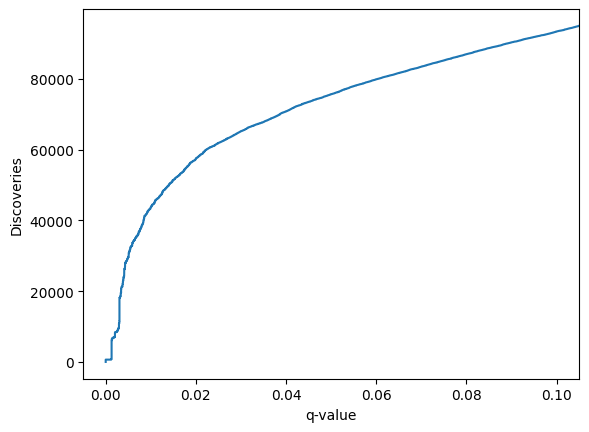

In [60]:
psm_df_after = calc_fdr(psm_df_after, 'SPC')
plot_qvalues(psm_df_after['fdr'])

In [61]:
# Prepare data for visualization (After Fine-tuning)
target_df_after = psm_df_after[psm_df_after['decoy'] == 0].copy()
decoy_df_after = psm_df_after[psm_df_after['decoy'] == 1].copy()

print(f"After Fine-tuning:")
print(f"  Total PSMs: {len(psm_df_after):,}")
print(f"  Target PSMs: {len(target_df_after):,}")
print(f"  Decoy PSMs: {len(decoy_df_after):,}")
print(f"  FDR range: {psm_df_after[fdr_col].min():.4f} - {psm_df_after[fdr_col].max():.4f}")


After Fine-tuning:
  Total PSMs: 338,839
  Target PSMs: 174,407
  Decoy PSMs: 164,432
  FDR range: 0.0000 - 1.0000


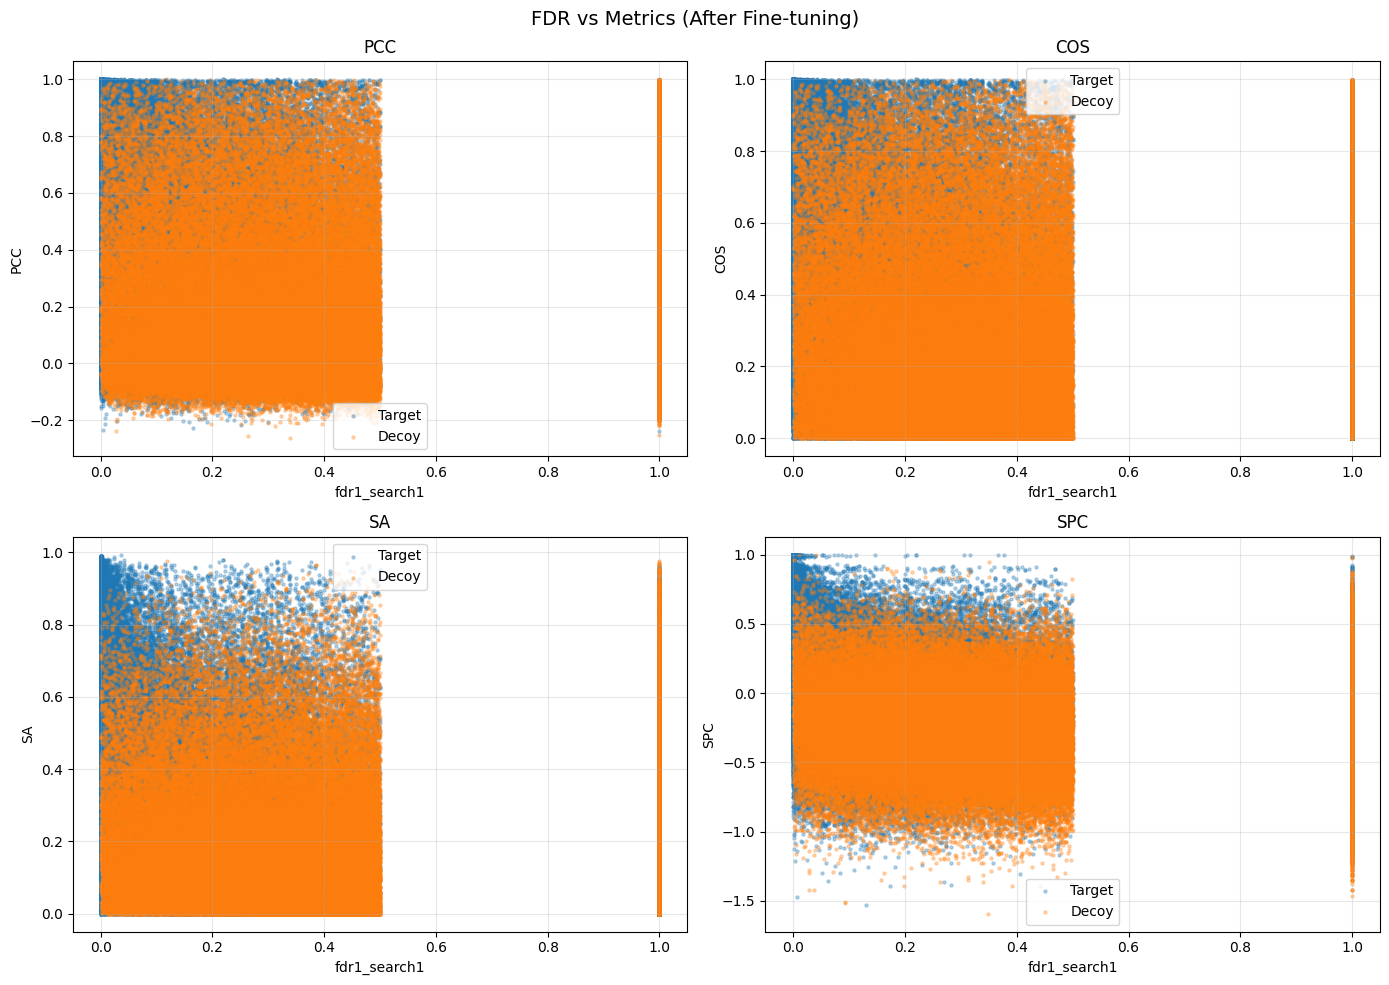

In [62]:
# Relationship: FDR vs Metrics (After Fine-tuning)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('FDR vs Metrics (After Fine-tuning)', fontsize=14)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    ax.scatter(target_df_after[fdr_col], target_df_after[metric], 
               alpha=0.3, s=5, label='Target')
    ax.scatter(decoy_df_after[fdr_col], decoy_df_after[metric], 
               alpha=0.3, s=5, label='Decoy')
    
    ax.set_xlabel(fdr_col)
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


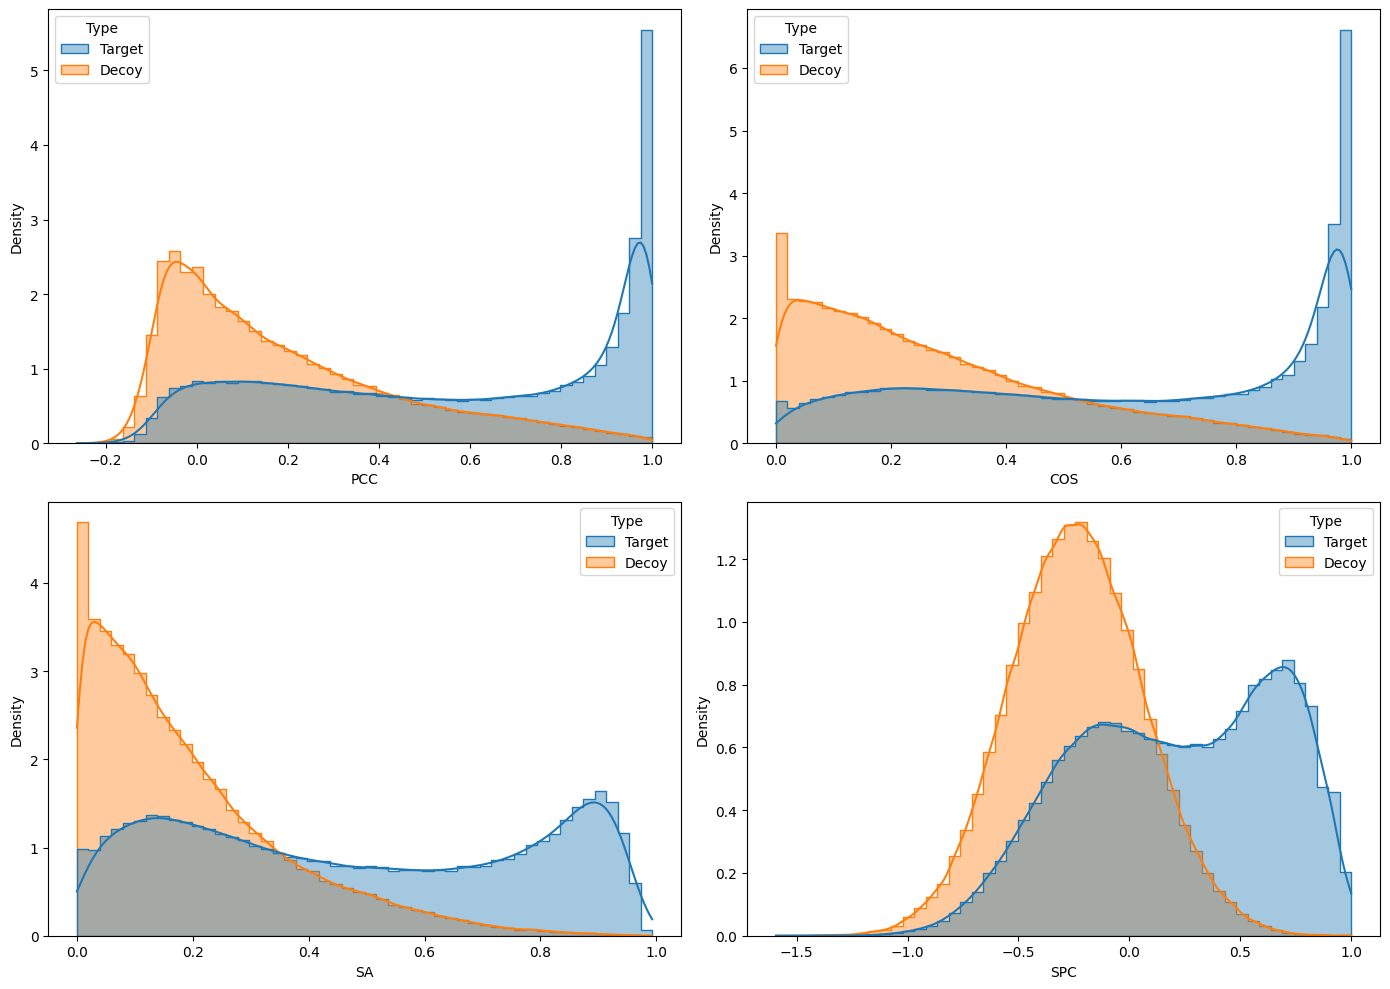

In [63]:
# Distribution: Metrics Distribution (After Fine-tuning)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    plot_target_decoy_dist(psm_df_after, metric, ax=ax)
plt.tight_layout()
plt.show()


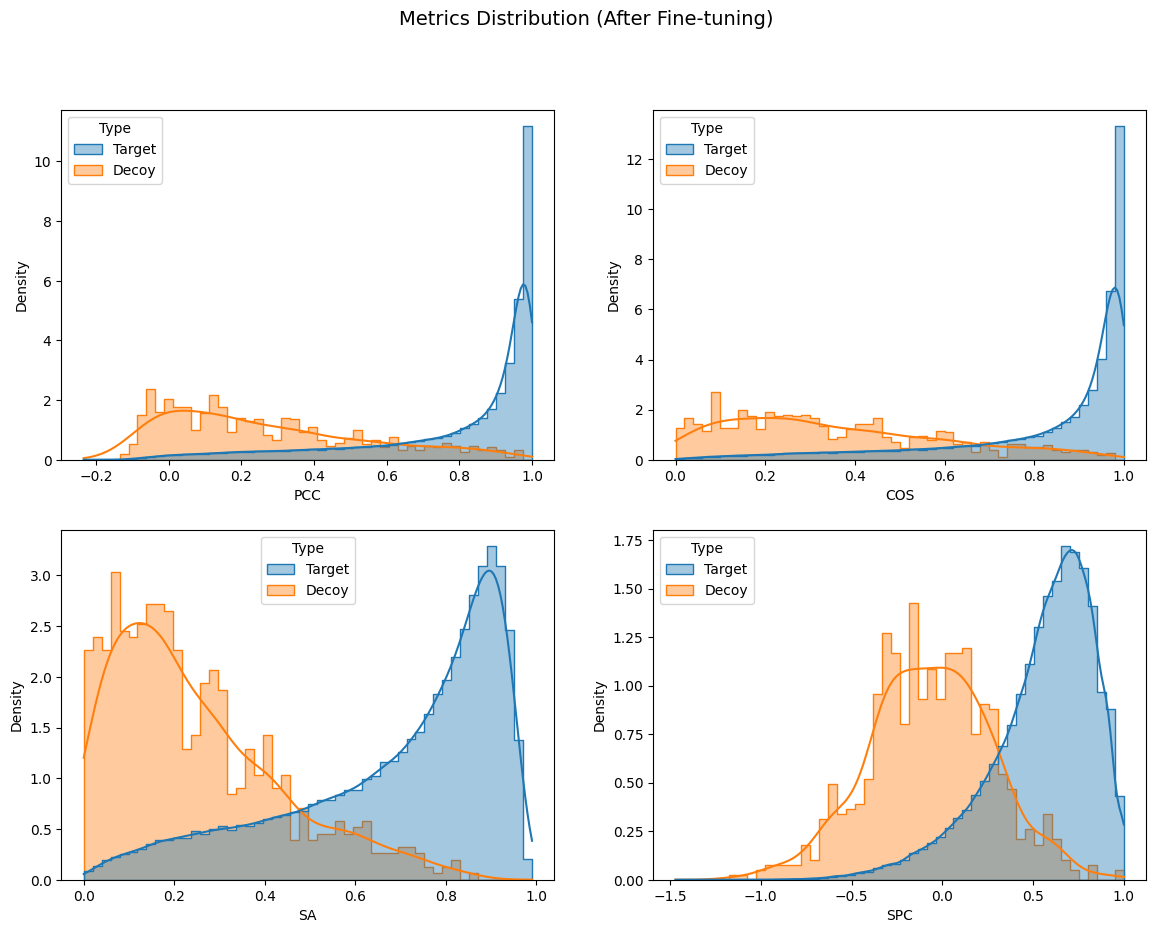

In [64]:
psm_df_after_filtered = psm_df_after[psm_df_after['fdr1_search1'] < 0.01]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Metrics Distribution (After Fine-tuning)', fontsize=14)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    plot_target_decoy_dist(psm_df_after_filtered, metric, ax=ax)

In [65]:
# Summary: After Fine-tuning
print("="*70)
print("Summary: After Fine-tuning")
print("="*70)

print("\n1. Overall Statistics:")
print(f"   Total PSMs: {len(psm_df_after):,}")
print(f"   Target PSMs: {len(target_df_after):,} ({len(target_df_after)/len(psm_df_after)*100:.1f}%)")
print(f"   Decoy PSMs: {len(decoy_df_after):,} ({len(decoy_df_after)/len(psm_df_after)*100:.1f}%)")

print("\n2. Mean Values:")
for metric in metrics:
    target_mean = target_df_after[metric].mean()
    decoy_mean = decoy_df_after[metric].mean()
    diff = target_mean - decoy_mean
    print(f"   {metric}: Target={target_mean:.4f}, Decoy={decoy_mean:.4f}, Diff={diff:+.4f}")

print("\n3. Statistics by Target/Decoy:")
print("\nTarget PSMs:")
print(target_df_after[metrics].describe())
print("\nDecoy PSMs:")
print(decoy_df_after[metrics].describe())


Summary: After Fine-tuning

1. Overall Statistics:
   Total PSMs: 338,839
   Target PSMs: 174,407 (51.5%)
   Decoy PSMs: 164,432 (48.5%)

2. Mean Values:
   PCC: Target=0.5542, Decoy=0.1958, Diff=+0.3584
   COS: Target=0.6101, Decoy=0.2871, Diff=+0.3231
   SA: Target=0.4801, Decoy=0.1947, Diff=+0.2853
   SPC: Target=0.2126, Decoy=-0.2397, Diff=+0.4522

3. Statistics by Target/Decoy:

Target PSMs:
                 PCC            COS             SA            SPC
count  174407.000000  174407.000000  174407.000000  174407.000000
mean        0.554181       0.610149       0.480063       0.212564
std         0.363949       0.322179       0.299357       0.453762
min        -0.239073       0.000000       0.000000      -1.531342
25%         0.214952       0.316028       0.204699      -0.150110
50%         0.600857       0.655946       0.455460       0.238867
75%         0.926709       0.937663       0.774031       0.611108
max         0.999941       0.999938       0.992918       1.000000

Decoy

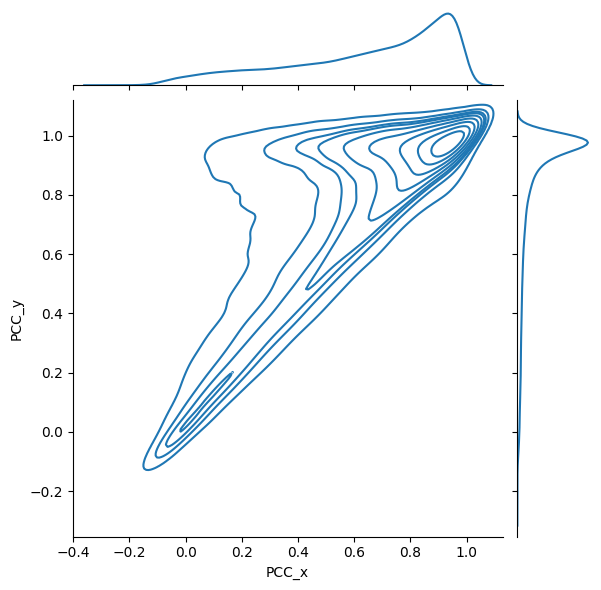

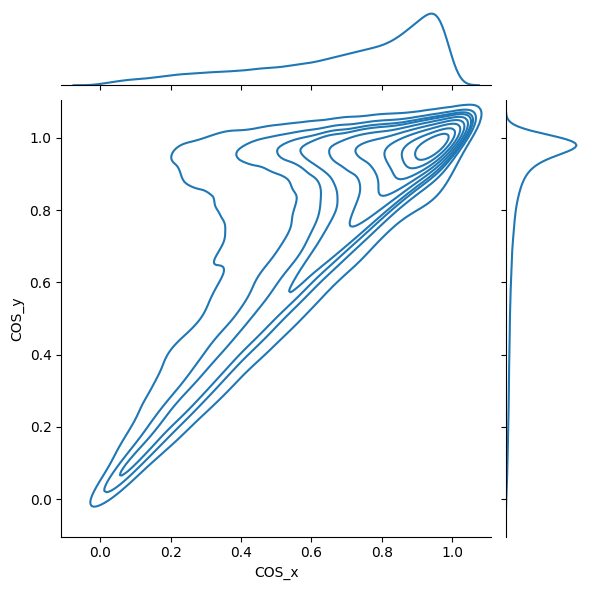

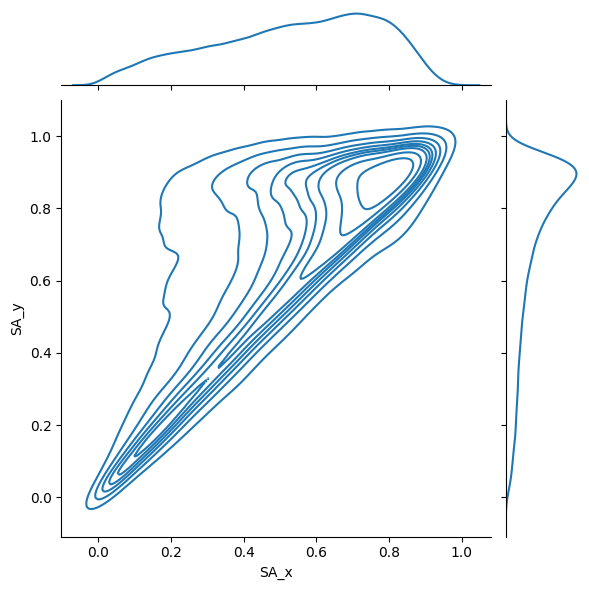

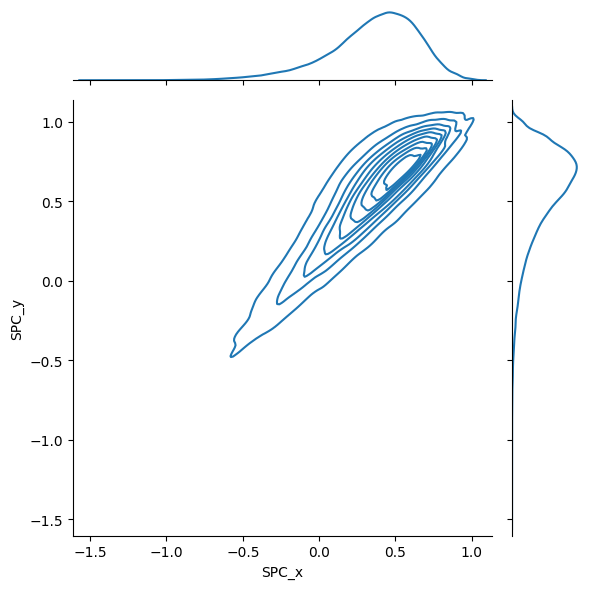

In [80]:
# merge psm_df_before and psm_df_after by raw_name, sequence, charge, mods, mod_sites on 4 metrics
psm_df_merged = pd.merge(psm_df_before, psm_df_after, on=['raw_name', 'sequence', 'charge', 'mods', 'mod_sites'], how='inner')
psm_df_merged_filtered = psm_df_merged[psm_df_merged['fdr1_search1_x'] < 0.01]
# 4 plot x axis is {metric}_x, y axis is {metric}_y, color is about density
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax = sns.jointplot(x=f'{metric}_x', y=f'{metric}_y', data=psm_df_merged_filtered, kind='kde')
plt.tight_layout()
plt.show()
